(irmf-chapitre)=
# IRM fonctionnelle

<table>
  <tr>
    <td align="center">
      <a href="https://github.com/anproulx">
        <img src="https://avatars.githubusercontent.com/u/65092948?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Andréanne Proulx</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
    <td align="center">
      <a href="https://github.com/pbellec">
        <img src="https://avatars.githubusercontent.com/u/1670887?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Pierre bellec</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
  </tr>
</table>

```{warning}
Ce chapitre est en cours de développement. Il se peut que l'information soit incomplète, ou sujette à changement.
```

## Objectifs du cours

[L'imagerie par résonnance magnétique fonctionnelle](https://fr.wikipedia.org/wiki/Imagerie_par_r%C3%A9sonance_magn%C3%A9tique_fonctionnelle)
est une modalité d'imagerie qui permet de mesurer indirectement l'activité cérébrale. L'IRMf acquière des images du cerveau en action en relation avec différentes conditions expérimentales, ayant été conçues pour isoler des processus cognitifs spécifiques. L'IRMf permet donc de cartographier l'organisation fonctionnelle du cerveau, dans différents contextes cognitifs.

```{figure} irm_fonctionnelle/irmf.jpg
---
width: 600px
name: irmf-ecran-fig
---
Les images d'IRMf permettent d'observer l'activation cérébrale, tiré de [wikipedia](https://fr.wikipedia.org/wiki/Imagerie_par_r%C3%A9sonance_magn%C3%A9tique_fonctionnelle#/media/Fichier:Researcher-test.jpg).
```
Les objectifs spécifiques du cours sont:
- Comprendre les principes **physiques** et **physiologiques** du signal en IRMf.
- Comprendre le modèle de la **réponse hémodynamique**, invariante dans le temps, qui permet d'estimer le niveau d'activation en réponse à divers paradigmes expérimentaux.
- Connaître les principales étapes de **pré-traitement** des données IRMf, soit le **recalage**, le **lissage spatial** et le **filtrage de facteurs de non-intérêt**. Ces étapes sont nécessaires afin de réduire le bruit dans le signal IRMf, qui ne reflète pas l'activité neuronale.
- Connaître le principe de génération d'une **carte d'activation**, qui, à l'aide de modèles statistiques, permet de tester des hypothèses sur l'organisation fonctionnelle du cerveau.

## Principes physiques et physiologiques

### Images 3D+t

|               |   `IRM structurelle`     | `IRM fonctionnelle (T2*)`  |
| ------------- |:-------------:| -----:|
| `Objet d'étude`      | **Anatomie, structures et propriétés des tissus** | **Organisation fonctionnelle**|
| `Dimension`     | 1 volume - **3D**   |  Plusieurs volumes dans le temps - **4D** |
| `Durée de l'acquisition` | Plusieurs minutes |  Secondes |


Les images d'IRMf sont un peu comme un film du cerveau en action. Elles sont composées d'une **série de volumes 3D** qui se succèdent à une fréquence donnée, plutôt que d'un unique volume comme c'était le cas en IRM. Nous parlons alors d'images **4D**, ou bien **3D+t** puisqu'aux dimensions spatiales (`x`, `y`, `z`) s'ajoute la dimension du temps `t`. Nous pourrions, par exemple, acquérir 1 volume cérébral toutes les 2 secondes, pendant 6 minutes, ce qui résulterait en un jeu de données d'IRMf composé de 180 volumes 3D du cerveau.

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


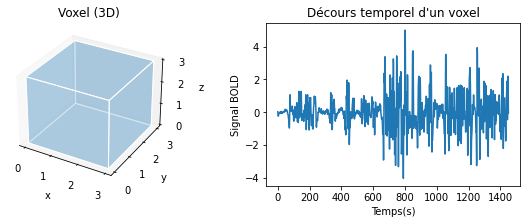

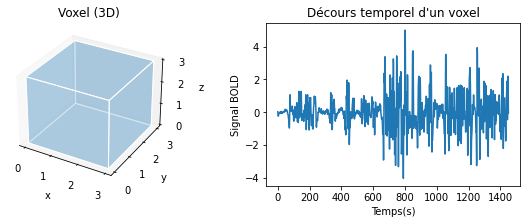

In [1]:
#importe les librairies nécessaires
import pandas as pd
import nilearn
import numpy as np
from nilearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Extraire les séries temporelles pour un sujet d'un jeu de données
haxby_dataset = datasets.fetch_haxby()
haxby_func_filename = haxby_dataset.func[0]

# initialiser le masque
brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

# appliquer le masque
brain_time_series = brain_masker.fit_transform(haxby_func_filename,
                                               confounds=None)
# fonctions de visualisations pour le voxel 3D
def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

# initialisation de la figure
fig = plt.figure(figsize=(10,3))

# visualiser le voxel
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.grid(False)
colors = np.array([[['#1f77b430']*1]*1]*1)
colors = explode(colors)
filled = explode(np.ones((1, 1, 1)))
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

x[1::2, :, :] += 1
y[:, 1::2, :] += 1
z[:, :, 1::2] += 1

ax1.voxels(x, y, z, filled, facecolors=colors, edgecolors='white', shade=False)
plt.title("Voxel (3D)")


# ajouter séries temporelles
# random voxel
voxel = 1
ax = fig.add_subplot(1, 2, 2)
ax.plot(brain_time_series[:, voxel])
ax.set_title("Décours temporel d'un voxel")

plt.xlabel("Temps(s)", fontsize = 10)
plt.ylabel("Signal BOLD", fontsize= 10)

from myst_nb import glue
glue("voxel-timeseries-fig", fig, display=False)

```{glue:figure} voxel-timeseries-fig
:figwidth: 800px
:name: "voxel-timeseries-fig"
Illustration d'un élément de volume (voxel), de taille 3 mm x 3 mm x 3 mm, et le décours temporel IRMf associé.
```

Le volume du cerveau (3D) est formé plusieurs milliers voxels, qui sont de petites unités de volumes (3D) ayant une coordonnée dans l'espace **x, y, z**. En IRMf, pour chaque voxel du cerveau, nous détenons plusieurs points de mesure de l'activité dans le temps, ce qui forme ce que l'on appelle une **série temporelle** ou **décours temporel**. Typiquement, quelques dizaines à centaines de points de mesures décrivent la série temporelle. Ces points de mesures sont séparées par un intervalle de temps, qui peut varier de millisecondes à secondes. Ces caractéristiques représentent un bon compromis entre résolution spatiale et temporelle. Comme nous le verrons plus loin, la série temporelle reflète de manière indirecte les changements d'activité neuronale dans le temps. Une grande partie du travail en IRM fonctionnelle consiste à analyser ces séries temporelles.


```{admonition} Compromis entre résolution spatiale vs temporelle en IRMf
:class: tip
:name: resolution

Lorsque l'on choisit une séquence d'IRMf, on est souvent amené à privilégier la résolution temporelle vs spatiale. On peut par exemple faire des images du cerveau entier en 700 ms avec une résolution spatiale de 3 x 3 x 3 mm$^3$, ou bien acquérir la même image avec une résolution spatiale de 2 x 2 x 2 mm$^3$, mais cette fois ci en 1500 ms. Il n'y a pas un choix de paramètre meilleur qu'un autre, mais la chercheuse doit décider si la résolution spatiale ou temporelle est plus importante pour ses questions de recherche.
```

### Couplage neurovasculaire

```{figure} irm_fonctionnelle/neurovascular-fig.jpg
---
width: 600px
name: neurovascular-fig
---
**Résumé de l'architecture neuro-gliale-vasculaire**. (a) Les astrocytes s'enveloppent autour des synapses, et ont des projections jusqu'à la surface des micro-cappilaires. (b) Les astrocytes établissent des domaines anatomiques exclusifs, qui chevauchent de manière minimale ceux de leurs voisins astrocytes. (c) Schéma représentant la morphologie d'une cellule gliale, avec un corps connecté à une structure en arbre. (d) Micro-circuit neuronal. (e) microvascularisation cérébrale. (f) illustration de la taille des micro-circuits neuronaux et de la vascularisation. (g) pourcentage d'occupation du volume dans l'espace du circuit. Figure tirée de l'article par Zisis et coll. (2021) {cite:p}`Zisis2021-ai`, sous licence CC-BY-NC-ND.
```

Le lien entre activité neuronale et signal IRMf repose sur le phénomène du **couplage neurovasculaire**, et plus spécifiquement le couplage entre l'activité post-synaptique des neurones et les micro-capillaires sanguins. La production de neurotransmetteurs dans la fente synaptique entrainent une série de réactions chimiques dans les cellules gliales avoisinantes. Lorsque l'activité neuronale augmente, les réactions chimiques qui l'accompagnent entrainent une **demande métabolique** en nutriments et ultimement l'extraction d'oxygène dans les micro-capillaires de manière locale. Les événements suivants se produisent alors:
 * augmentation du volume des capillaires;
 * augmentation du flux sanguin;
 * augmentation l'acheminement en oxygène (oxyhémoglobine) vers les populations de neurones actives.

 L'augmentation d'extraction d'oxygène entraine donc de manière paradoxale une augmentation locale de la concentration en d'**oxyhémoglobine** (sang oxygéné) par rapport à la concentration en **déoxyhémoglobine** (sang déoxygéné) localement, ce qui est dédectable au moyen de l'IRMf. Le premier modèle quantitatif du couplage neurovasculaire (dit “modèle du ballon”) a été proposé par Buxton et coll. (1998) {cite:p}`Buxton1998-jy`.


### Le signal BOLD
```{figure} ./irm_fonctionnelle/hemoglobine-fig.jpg
---
width: 600px
name: hemoglobine-fig
---
Illustration du transport de l'oxygène par l'hémoglobine dans le sang. Image par [ShadeDesign](https://www.shutterstock.com/g/ShadeDesign) disponible sur [shutterstock](https://www.shutterstock.com/image-illustration/vector-science-medical-icon-blood-hemoglobin-1472480087) ID `1472480087`, utilisée sous licence shutterstock standard.
```

Quelle est l'origine du **signal BOLD**? L'hémoglobine existe sous deux états, soit l'état oxygéné (porteur de l'oxygène) et déoxygéné (non-porteur d'oxygène). La présence de l'oxygène modifie les propriétés éléctromagnétiques de cette molécule:
- L'**oxyhémoglobine** est **diamagnétique**
- La **déoxyhémoglobine** est **paramagnétique**

Ce que cela veut dire, c'est que quand elles sont soumises à des impulsions électromagnétiques, ces deux molécules se comportent de manière très différente. La déoxyhémoglobine va créer des inhomogénéités du champ magnétique, alors que l'oxyhémoglobine n'a pas d'effet sur ce même champ. Les séquences IRM pondérées $T_2^*$ sont très sensibles à de telles inhomogénéités. La déoxyhémoglobine déforme donc le champ magnétique $B_O$ induit par l'aimant, ce qui fait en sorte que le temps de relaxation $T_2^*$ est plus rapide. Les images acquises en IRMf utilisent donc un contraste en $T_2^*$, et cela a pour effet d'amplifier le signal quand le sang devient plus oxygéné en réponse à une augmentation de l'activité neuronale. Pour cette raison, le signale utilisé en IRMf est appelé signal BOLD, pour _Blood oxygenation level-dependent_, soit signal dépendant de l'oxygénation du sang.

|               |   `Déoxyhémoglobine`     | `Oxyhémoglobine`  |
| ------------- |:-------------:| -----:|
|Propriétés électromagnétiques |Diamagnétique| Paramagnétique|
| Impact sur le signal BOLD      | **Réduit** le signal BOLD  | **Augmente** le signal BOLD|
| $T2$*    | Décroît plus **rapidement**   |   Décroît plus **lentement** |
| Effet sur le champ | **Ajout d'inhomogénéités/distorsions** |  **Pas d'inhomogénétités**  |


```{admonition} Attention!
:class: caution attention
:name: neurovascular-warning

Le signal BOLD en IRMf constitue une **mesure indirecte** de l'activité neuronale. En effet, cette modalité ne mesure pas directement l'activité des neurones, mais plutôt les conséquences vasculaires de la demande métabolique associée à l'activité neuronale. Cette relation de **couplage neurovasculaire** est très complexe, et fait intervenir de nombreux métabolites et mécanismes différents.
```

### Fonction de réponse hémodynamique

#### Réponse à une impulsion courte

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


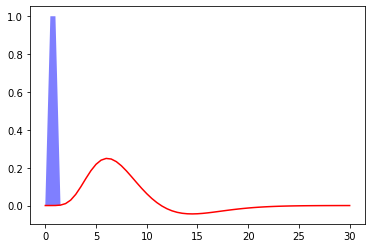

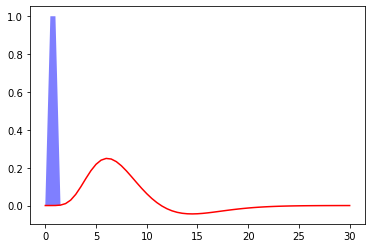

In [2]:
# To get an impulse response, we simulate a single event
# occurring at time t=0, with duration 1s.
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

# Now we plot the hrf
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))

# obtain the signal of interest by convolution
signal, name = compute_regressor(
    exp_condition, 'glover', frame_times, con_id='main',
    oversampling=16)

# plot this
plt.fill(frame_times, stim, 'b', alpha=.5, label='stimulus')
plt.plot(frame_times, signal.T[0], 'r', label=name[0])

# Glue the figure
from myst_nb import glue
glue("hrf-fig", fig, display=False)

```{glue:figure} hrf-fig
:figwidth: 800px
:name: "hrf-fig"
Réponse hémodynamique à une impulsion unitaire d'une durée de seconde, suivant le modèle proposé par Glover and coll. (1999) {cite:p}`Glover1999-cb`. Le code pour générer cette figure est adaptée d'un [tutoriel](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py) Nilearn, et la figure est sous licence CC-BY.
```
La figure qui suit montre la réponse hémodynamique attendue suite à une impulsion finie d'activation au temps 0, et de durée 1 seconde. La réponse à ce type de stimulus permet de visualiser la réponse hémodynamique la plus largement utilisée, décrivant relation maintenue entre l'activité neuronale (rouge) et le signal BOLD (bleu), en fonction du temps. L'axe `x` représente le temps, en secondes, et l'axe `y` le signal cérébral, exprimé en pourcentage du changement par rapport à une ligne de base. Les caractéristiques importantes de la fonction de réponse hémodynamique sont:

- **la résolution temporelle**: il s'agit d'une réponse lente, qui dure entre **15 à 20 secondes** suivant le stimulus
- **le temps avant l'atteinte de l'amplitude maximale**: de **4 à 6 secondes**
- **Creux post-stimulation (*Undershoot* en anglais)**: décroît à partir de l'amplitude maximale jusqu'à se retrouver sous la ligne de base.
- **Retour à la ligne de base**: La fonction retrouve le niveau précédant la stimulation après environ **15 à 20** secondes
- **Amplitude maximale**: L'ordre du changement relatif du signal BOLD atteint environ **5%** pour des stimulations d'ordre sensorielle, alors qu'elle est plutôt de **0,1 à 0,5%** pour d'autres paradigmes cognitifs

```{admonition} Attention!
:class: tip
:name: adéquation du modèle-tip

Le modèle de réponse hémodynamique ci dessus est très rigide et peut s'avérer être une hypothèse invalide pour certaines populations, notamment si le couplage neurovasculaire est différent de l'étude originale de Glover and coll. (1999) {cite:p}`Glover1999-cb`. C'est probablement le cas, par exemple, chez les personnes âgées ou chez les individus ayant des maladies cardiovasculaires. La fonction de réponse hémodynamique peut également varier d'une région du cerveau à l'autre. Il est possible d'utiliser des modèles de la réponse hémodynamique qui sont plus flexibles et permettent, par exemple, de modifier le temps du pic de la réponse.
```

#### Le cerveau (BOLD) comme un système
```{figure} ./irm_fonctionnelle/systeme-fig.png
---
width: 400px
name: systeme-fig
---
Un système prend un décours temporel d'entrée et lui associe un décours temporel de sortie. Figure sous licence CC-BY.
```

Le processus qui transforme l'activité neuronale en un signal BOLD peut se formaliser dans le cadre général de la théorie des systèmes. Plus spécifiquement, la fonction de réponse hémodynamique de la {numref}`hrf-fig` est généralement approximée comme un système linéaire et invariant dans le temps. Cette approximation sous-tend les inférences que l'on fait sur l'organisation fonctionnelle du cerveau: nous l'employons dans le but d'estimer la réponse à une tâche ou condition donnée. La fonction de réponse hémodynamique de la {numref}`hrf-fig` se rapporte à un contexte expérimentale simple: une stimulation courte et isolée. En réalité, les **paradigmes expérimentaux sont beaucoup plus complexes**: ils alternent à maintes reprises entre différentes conditions expérimentales/stimuli (par blocs, aléatoirement ou dans un ordre précis). De plus, ils comportent souvent plus d'une stimulation rapprochée dans le temps, ou/et des stimuli qui se prolongent sur plusieurs millisecondes ou secondes. Qu'advient-il alors de la fonction de réponse hémodynamique? Une propriété clé d'un système linéaire est d'être additif, c'est à dire que la réponse à une stimulation longue peut être décomposée comme la superposition de réponses à des stimulations plus courtes. Une autre hypothèse clé est l'**invariance dans le temps**, qui nous dit que la réponse du système ne va pas varier si on effectue la même stimulation courte à différents instants. Quand on **combine** l'hypothèse de linéarité avec l'invariance dans le temps, il est possible de prédire la réponse à n'importe quelle série de stimuli complexe à partir de la réponse à une unique stimulation courte, comme présentée en {numref}`hrf-fig`. L'étude de Logothetis et al. (2001) {cite:p}`Logothetis2001-lt` a été la première à démontrer chez le singe que cette hypothèse de linéarité et d'invariance semble être assez bien respectée, au moins dans le cortex visuel pour des stimuli visuels simples (contexte de l'étude).

```{admonition} Additivité
:class: tip
:name: additivité-tip
Un système est dit **additif** si la réponse à plusieurs impulsions correspond à la somme des réponses à ces impulsions prises indépendamment. Ce comportement est illustré ci-dessous.

```{figure} ./irm_fonctionnelle/systeme-additif-fig.png
---
width: 400px
name: systeme-additif-fig
---
Figure sous licence CC-BY.
```

## Prétraitement des données d'IRMf
Nous avons abordé dans les sections précédentes divers aspects de la modélisation de la réponse hémodynamique. Un autre point important en IRMf est la modélisation du bruit et des sources de variations qui peuvent être présentes dans les séries temporelles. Différents **facteurs confondants** et **artéfacts** (provenant du scanner IRM ou du sujet scanné lui-même) peuvent induire des fluctuations substantielles dans le signal BOLD mesuré, et venir confondre les inférences faites sur l'activité neuronale en réponse à des tâches:

- bruit cardiaque,
- artéfact lié au mouvement du sujet lors de l'acquisition,
- défaut dans l'antenne,
- inhomogénéités dans le champ magnétique, notamment aux intersections air-tissu,
- différences entre l'anatomie des sujets.

Différentes stratégies de modélisation peuvent être employées pour réduire l'influence des facteurs confondants et des artéfacts. Dans cette section, nous présentons un aperçu de trois grandes étapes de prétraitement en IRMf, qui, typiquement sont appliquées séquentiellement. On parle de _chaine de traitements_, ou encore _pipeline_ ou _worflow_ en anglais.

### Recalage

Le recalage consiste à aligner une image à une image de référence. C'est une étape de prétraitement complétée avant les analyses statistiques de groupe, comme celles-ci présupposent qu'il y a une correspondance entre les voxels des images provenant de différents sujets. Nous avons déjà discuté du {ref}`recalage <registration-tip>` dans la section sur la [morphometrie](morphometrie). Nous allons voir que trois types de recalage sont utilisés en IRM fonctionnelle.

#### Recalage du mouvement
```{figure} ./irm_fonctionnelle/mouvement-fig.png
---
width: 500px
name: mouvement-fig
---
Illustration du processus de recalage du mouvement au cours d'un examen d'IRMf. Figure sous licence CC-BY.
```
Souvent, le sujet ne maintient pas exactement la même position de la tête dans le scanner tout au long des acquisitions, qui peuvent parfois durer plus d'une heure et/ou exiger des arrêts. (p.e. baillements, fatigue musculaire, clignement de yeux, etc.). Ces mouvements ont des impacts non-négligeables sur le signal BOLD. Ils peuvent entraîner des distorsions de l'intensité du signal de l'image. Ils impliquent que, d'une image à l'autre, un même voxel ne correspond pas nécessairement à la même structure cérébrale. Comme le cerveau d'un même individu ne change pas de forme ou de taille à travers les acquisitions, cette étape utilise un cas particulier de transformation affine, appelée transformation rigide, ne comportant que trois translations (selon `x`, `y` et `z`) et trois rotations (selon `x`, `y` et `z`). On utilise un volume de référence comme cible pour le recalage, par exemple le premier volume de la série, le dernier, ou bien la moyenne de tous les volumes. Différents paramètres de mouvement sont estimés pour chaque volume, et peuvent être représentés au cours du temps comme sur le graphique ci dessus.

```{admonition} Mouvements excessifs
:class: tip
:name: motion-tip
Le niveau de mouvement varie en fonction de la population étudiée. Les enfants et les personnes âgés ont tendance à bouger davantage que les jeunes adultes. Certains chercheurs choisissent d'exclure les sujets ayant bougé au-delà d'un certain seuil
```

#### Recalage BOLD avec $T_1$
Il est commun d'aligner l'image BOLD avec l'image anatomique $T_1$ du sujet. Pourquoi? L'image fonctionnelle détient une moins bonne résolution spatiale que l'image structurelle $T_1$: nous avons de plus courtes durées d'acquisition pour acquérir un même volume. Le contraste entre structures anatomiques est aussi bien meilleur en $T_1$. Il est donc utile de superposer les deux images pour localiser les activations BOLD. Cette transformation est estimée de manière rigide, comme le mouvement. Notez qu'il existe aussi des déformations


#### Recalage dans l'espace stéréotaxique
Pour les comparaisons inter-individuelles ou les analyses statistiques de groupe, il doit y avoir une correspondance entre les voxels des images provenant de différents individus. Or, les cerveaux et les structures anatomiques peuvent avoir différentes tailles et formes d'individus en individus. Le recalage dans l'espace stéréotaxique, aussi parfois appelée _normalisation spatiale_, consiste à recaler l'image $T_1$ dans un espace standard cible défini par l'atlas choisi, rendant ainsi comparables les cerveaux de différents individus. Cette technique a identique à ce qui est fait pour les études de morphométrie. Le template MNI152 (Montreal Neurological Institute) est largement employé comme espace standard dans la communauté. Cette transformation combine une transformation affine et une transformation non-linéaire.

#### Lissage spatiale

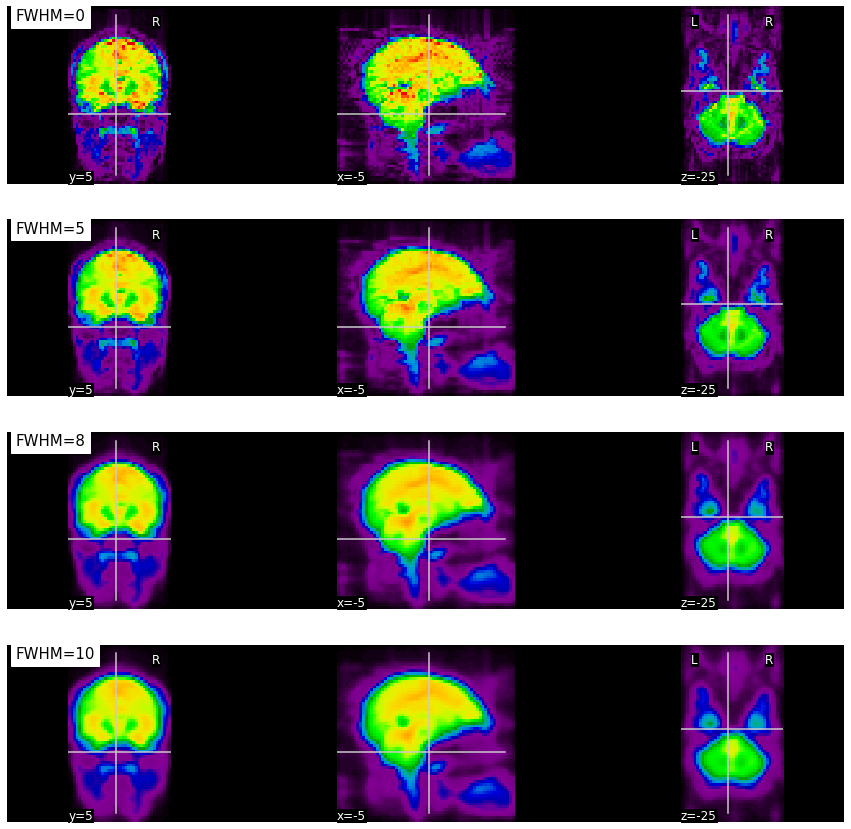

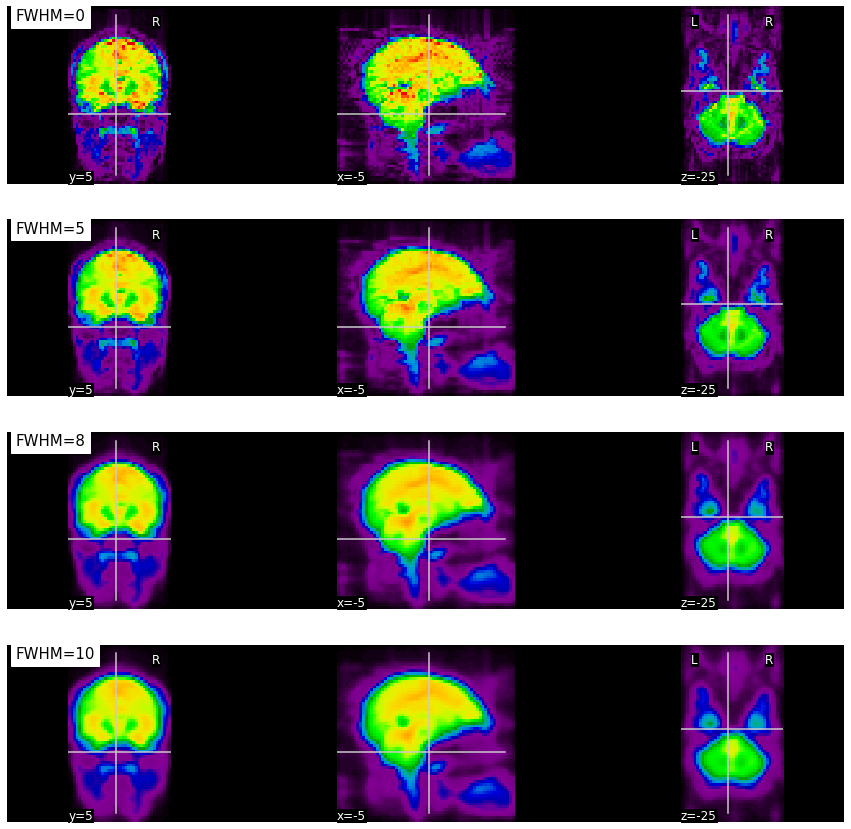

In [3]:
# Importe les librairies nécessaires
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Télécharge un scan fonctionnel (Haxby)
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# calcule le volume moyen
from nilearn.image.image import mean_img
func_filename = haxby_dataset.func[0]
mean_haxby = mean_img(func_filename)

from nilearn.plotting import plot_epi, show

# Initialise la figure
fig = plt.figure(figsize=(15, 15))

from nilearn.plotting import plot_anat
from nilearn.image import math_img
from nilearn.input_data import NiftiMasker
from nilearn.image import smooth_img

list_fwhm = (0, 5, 8, 10)
n_fwhm = len(list_fwhm)
coords = [-5, 5, -25]

for num, fwhm in enumerate(list_fwhm):
    ax_plot = plt.subplot2grid((n_fwhm, 1), (num, 0), colspan=1)
    vol = smooth_img(mean_haxby, fwhm)
    plot_epi(vol,
              cut_coords=coords,
              axes=ax_plot,
              black_bg=True,
              title=f'FWHM={fwhm}',
              vmax=1500)

from myst_nb import glue
glue("smoothing-fmri-fig", fig, display=False)

```{glue:figure} smoothing-fmri-fig
:figwidth: 600px
:name: smoothing-fmri-fig
Illustration de l'impact du lissage sur un volume BOLD.
À mesure que le paramètre `FWHM` augmente, la mesure en un voxel représente la moyenne dans un voisinage spatial de plus en plus grand.
Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) à partir du jeu de données `haxby` (cliquer sur + pour voir le code). La figure est sous license CC-BY.
```
Nous revenons ici sur une étape de prétraitement que nous avons déjà abordé lors du cours sur la VBM: le lissage spatial. Le processus du lissage est semblable pour l'IRM fonctionnelle, mais la portée de cette étape est un peu différente comme l'image est dynamique (l'objet de ce lissage ne sont pas les valeurs de l'intensité de l'image comme en IRM structurelle, mais plutôt celles du signal BOLD). Certains artéfacts, comme le mouvement du sujet au cours de l'acquisition, peuvent entraîner des pics/fluctuations aléatoires dans le signal BOLD, et avoir un effet néfastes sur les analyses statistiques. Le lissage spatiale entre alors en jeu : il a pour effet de diminuer le bruit, en éliminant la contribution des fluctuations aléatoires ciblant des voxels spécifiques. De manière plus opérationnelle, le lissage consiste à prendre les voxels de l'image et à les remplacer par une nouvelle valeur considérant les valeurs des voxels voisins. Chaque voxels voisins se voit attribuer une pondération qui quantifie sa contribution à la nouvelle valeur attribué à un voxel cible. La valeur originale du voxel cible est celle qui aura la plus grande pondération, et les valeurs des voxels voisins seront pondérés en fonction de la proximité entretenue avec le voxel cible. Mis à part l'amélioration du ratio signal-bruit, le lissage permet également d'atténuer les erreurs/imperfections de recalage inter-sujet.

Le paramètre `FWHM` (*full width at half maximum*) contrôle l'échelle de ce lissage (plus important ou moins important). Il détermine l'étalement des voxels voisins qui participeront à la nouvelle valeur d'un voxel cible. D'un point de vue mathématique, le paramètre `FWHM` représente la demi de la largeur de la courbe gaussienne, qui décrit du bruit distribuée aléatoirement. Une plus grande valeur `FWHM` sous-tend une participation plus étalée des voxels voisins à la nouvelle valeur  d'un voxel cible de l'image. Plusieurs études choisissent `6 mm` comme valeur pour le paramètre `FWHM`.

#### Filtrage des facteurs de non-intérêt
La dernière étape de prétraitement qui sera abordé est celle du filtrage de facteurs de non-intérêt. Différents **facteurs confondants** ou **artéfacts** peuvent induire des fluctuations dans le signal BOLD. Ces artéfacts peuvent avoir différentes fréquences du spectre, soit plus lentes ou rapides. Lorsque ce bruit est systématique ou périodique, il possible de le régresser (c'est-à-dire de le retirer) en employant différentes stratégies comme des filtres. Les dérives lentes constituent un exemple commun de facteurs de non-intérêt, et elles sont assez facilement repérables dans le signal. Dans ce cas, pouvons appliquer un filtre passe-haut, qui conserve uniquement les fréquence plus haute qu'un certain seuil (p.e. 0.01 Hz).


## Analyses statistiques

Cette section est un aperçu général du cours sur les analyses statistiques à venir. Nous laisserons certains détails de côté pour le moment, mais nous y reviendrons dans le cours 6 sur les [analyses statistiques](https://psy3018.github.io/cartes_statistiques.html). Rappelons une fois de plus nos objectifs en IRMf : nous voulons dégager de nouvelles connaissances sur le fonctionnement du cerveau. Ceci implique le recours à des analyses statistiques.

Les analyses statistiques comportent généralement des **analyses individuelles** dans lesquelles les séries temporelles sont analysés séparément pour chacun des sujets (on analyse l'effet des manipulations expérimentales), puis des **analyses de groupe** (on analyse l'effet de groupe), où ces données sont combinées pour plusieurs sujets pour être analysées.

### IRMf - Expérience basée sur une tâche
Pour déterminer si l'activité des voxels du cerveau changent en réponse à des manipulations expérimentales, une approche expérimentale standard consiste à manipuler la tâche que réalise le sujet dans le scanneur, par exemple en alternant différentes conditions par blocs (yeux ouverts, yeux fermés). Nous avons ensuite recours à des constrastes, aussi appelées analyse de soustraction qui procède en comparant les séries temporelles d'une condition à une autre condition, ou à un seuil de base. Ces contrastes sont répétées pour chacun des voxels du cerveau.


```{admonition} Problème de comparaisons multiples
:class: tip
:name: comparaisons multiples-tip
Les analyses statistiques en IRMf surviennent dans un contexte particulier. Ce sont des analyses massivement univariées, c'est-à-dire que nous avons des tests statistiques répétés plusieurs milliers de fois (à chacun de nos voxels). Ceci entraîne un problème de comparaisons multiples qui requiert une correction pour l'inflation de faux positifs. Ceci sera abordé plus en détail dans le cours sur les analyses statistiques.
```

```{admonition} Paradigmes classiques
:class: tip
:name: paradigmes classiques-tip
Les premiers paradigmes expérimentaux en IRMf consistaient à répéter un tâche pendant la durée de l'acquisition, puis à contraster avec un seuil de base en utilisant des procédures statistiques comme le test-t. Inspiré par ces approches, les premières études faisait la différence entre la moyenne d'activation lors de tâche et à l'état de repos. Dans l'études par Kwong et al. (1992) par exemple, des blocs de stimulations visuels étaient suivis de blocs sans stimulation.
```

### Régression univariée
Il est possible de généraliser l'analyse de soustraction pour tenir compte de **1) la forme de la réponse hémodynamique**
**2) la présence de plusieurs conditions dans une même expérience**. Tel que soulevé précédemment, une grande partie du travail en IRMf consiste à analyser/expliquer les séries temporelles. Nous pouvons utiliser nos connaissances sur la fonction de réponse hémodynamique, ainsi que celles sur les conditions du paradigme expérimental, pour estimer le niveau d'activation BOLD dans une condition (nous irons plus dans les détails ultérieurement, mais globalement celles-ci deviennent les variables explicatives dans des modèles de régressions qui tente d'expliquer les séries temporelles). Les séries temporelles sont aussi expliquer comme étant partiellement **3) du bruit/erreur**, que l'on suppose aléatoire. Nous ajustons les paramètres de ce modèle tenant compte **1)**, **2)** et **3)**. Ceux-ci sont mis à l'échelle : c'est ce qui nous permet de connaître le niveau d'activation pour une condition. Une fois ce niveau connu, il peut être contrasté entre différentes conditions ou avec un niveau de base, en calculant la différence entre les moyennes d'activation de chaque condition respectivement. En employant une distribution gaussienne, nous pouvons évaluer la probabilité d'observer une telle différence, ou n'importe quelle statistique donnée (p.e. test-t). Le formalisme décrit ci-haut s'appelle le modèle linéaire général. On en reparlera au cours 5.

### IRMf - Cartes d'activation

In [4]:
# activation related to a mental computation task, as opposed to narrative sentence reading/listening
# librairies
from nilearn import datasets
import pandas as pd
#from nilearn.glm import threshold_stats_img, SecondLevelModel
from nilearn import plotting

n_samples = 20
localizer_dataset = datasets.fetch_localizer_calculation_task(
    n_subjects=n_samples)
cmap_filenames = localizer_dataset.cmaps

design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])

#z_map = second_level_model.compute_contrast(output_type='z_score')

#thresholded_map1, threshold1 = threshold_stats_img(
#    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)

# visualiser
# sans seuil
#display = plotting.plot_stat_map(z_map, title='Carte activation')

# avec seuil
#plotting.plot_stat_map(
#    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
#    title='Carte activation avec seuil, fdr <.05')

Les cartes d'activation sont souvent ce que l'on retrouvent dans des articles scientifiques dans la section des résultats. Ce sont des cartes du cerveau sur lesquelles se superposent les statistiques obtenues (p.e. niveau d'activation, test-t, valeur p). Elles sont supersposées vis-à-vis des voxels ou régions correspondant(e)s. Ces cartes peuvent être construites pour des **sujets** (p.e. effet yeux ouverts vs yeux fermés) ou des **groupes**, si nous combinons les données de plusieurs sujets (p.e. effet de l'âge ou d'appartenir au groupe non-voyant vs voyant). Elles sont souvent présentées suite à l'application de seuils ou de masques, venant isoler les régions les plus actives, avec les différences moyennes entre conditions les plus importantes et/ou les plus statistiquement significatives. Via de telles cartes, nous pouvons étudier l’organisation de systèmes d'intérêt (visuel, moteur, auditif, mémoire de travail, etc), mais aussi comparer des groupes ou bien associer le niveau d’activation à des traits d'intérêt comme le QI. La faisabilité de cette approche a été démontrée simultanément par trois groupes: *Ogawa et al. PNAS 1992; Kwong et al. PNAS 1992; Bandettini et al. MRM 1992*, ayant introduit l'idée de cartographier le cerveau avec des tâches en IRMf.

```{admonition} Origines de la ségrégation fonctionnelle
:class: tip
:name: histoire-tip
De nos jours, une partie importante de la littérature suppose que le cerveau est découpé en aires fonctionnelles, en d'autre mots, elle admet le principe de ségrégation fonctionnelle. L'idée de localiser les fonctions cognitives n'est pas une idée nouvelle. Dans les faits, c'était l'idée de Gall, avec la phrénologie, qui assumait un lien entre la morphologie du crâne et les fonctions cognitives. Selon la phrénologie, la forme de la boîte crânienne est informative des tendances des individus. Les aires du cerveau sont organisées selon des concepts cognitifs comme "counsciousness", "destructiveness" et autres dimensions. Bien que peu rigoureuse, cette idée est revisitée dans le cadre de la modalité de l'IRMf, mais avec bien plus de rigueur scientifique. Son émergence légitime dans le discours scientifique remonte, notamment, aux travaux de Brodmann lequel employait des techniques de teintures pour observer la forme et variations des cellules nerveuses (cytoarchitecture) à travers le cortex. Nous admettons, aujourd'hui, arriver à accéder à certains aspects de l'organisation fonctionnelle cérébrale.
```

## Conclusions
La réalisation d'une expérience d'IRMf nécessite de bien penser les conditions d'intérêts et de contrôles pour isoler des processus cognitifs pertinents, mais cela requiert aussi de réfléchir aux hypothèses sous-jacentes. Nous débutons généralement avec une hypothèse scientifique qui postule que certaines manipulations expérimentales vont guider des différences observables dans des régions d'intérêt. Nous poursuivons avec des hypothèses neuronales : les populations de neurones vont s'activer en réponse à nos conditions. Nous supposons que la réponse neuronale sera couplée à une réponse vasculaire caractéristique qu'il est possible de modéliser avec la fonction hémodynamique, laquelle est linéaire et invariante dans le temps. Finalement, nous faisons des hypothèses sur la généralisabilité de nos résultats.

## Références
```{bibliography}
:filter: docname in docnames
```

## Exercices
```{admonition} Exercice 4.1
:class: note
Choisissez la bonne réponse. Des données d’IRMf sont en général...
 1. Une image du cerveau.
 2. Une dizaine d’images du cerveau.
 3. Des centaines d’images du cerveau.
```

```{admonition} Exercice 4.2
:class: note
Qu’est ce que le signal BOLD? (vrai / faux).
 1. Un signal très courageux.
 2. Une séquence pondérée en T2*.
 3. Un type de séquence d’IRM qui mesure l’activité du cerveau.
 4. Un type de séquence d’IRM qui mesure l’oxygénation du sang.
```

```{admonition} Exercice 4.3
:class: note
Choisissez la bonne réponse. Le signal BOLD dépend sur...
 1. Le flux sanguin local.
 2. Le volume sanguin local.
 3. La concentration relative en désoxyhémoglobine.
 4. Toutes les réponses ci-dessus.
```

```{admonition} Exercice 4.4
:class: note
Vrai / faux. Le principe d’additivité de la réponse hémodynamique est...
 1. Un modèle mathématique.
 2. Une propriété bien connue du couplage neurovasculaire.
 3. Une hypothèse courante, en partie confirmée expérimentalement.
```

```{admonition} Exercice 4.5
:class: note
Quel est l’événement principal à l’origine des changements de signal mesuré par le BOLD?
```

```{admonition} Exercice 4.6
:class: note
Dans quelle portion de l’arbre vasculaire observe-t-on les changements principaux liés à l’activité neuronale locale?
```

```{admonition} Exercice 4.7
:class: note
Vrai / faux?
 1. La réponse hémodynamique démarre immédiatement après l’excitation neuronale.
 2. La réponse hémodynamique est visible une seconde après l’excitation neuronale.
 3. La réponse hémodynamique est maximale 2 secondes après l’excitation neuronale.
 4. La réponse hémodynamique est toujours visible 7 secondes après l’excitation neuronale.
 5. La réponse hémodynamique est toujours visible 30 secondes après l’excitation neuronale.
```

```{admonition} Exercice 4.8
:class: note
Vrai / faux / peut-être? (expliquez pourquoi)
 1. Les données IRM fonctionnelle et structurelle doivent être réalignées pour générer une carte d’activation.
 2. Les données d’IRMf “brutes” (avant prétraitement) sont inutilisables pour générer une carte d’activation.
 3. Le lissage spatial est important, même pour une analyse individuelle.
```

```{admonition} Exercice 4.9
:class: note
On compare l’activation pour une tâche de mémoire dans le cortex frontal entre deux groupes de participants: des sujets sains et des sujets âgés (N=20 par groupe). Contrairement à nos hypothèses, on ne trouve aucune différence. Donnez trois raisons qui peuvent expliquer ce résultat.
```